## Zadanie domowe - Algorytm Canny'ego

Celem zadania domowego jest wykonanie pełnej implementacji algorytmu Canny'ego.

W ramach ćwiczenia w trakcie laboratorium wyznaczono obrazy $g_{NH}$ i $g_{NL}$.
Dla przypomnienia:
Można powiedzieć, że na obrazie $g_{NH}$ są "pewne" krawędzie.
Natomiast na $g_{NL}$ "potencjalne".
Często krawędzie "pewne" nie są ciągłe.
Wykorzystuje się więc krawędzie "potencjalne", aby uzupełnić nieciągłości.
Procedura wygląda następująco:
1. Stwórz stos zawierający wszystkie piksele zaznaczone na obrazie $g_{NH}$.
W tym celu wykorzystaj listę współrzędnych `[row, col]`.
Do pobrania elementu z początku służy metoda `list.pop()`.
Do dodania elementu na koniec listy służy metoda `list.append(new)`.
2. Stwórz obraz, który będzie zawierał informację czy dany piksel został już odwiedzony.
3. Stwórz obraz, który zawierać będzie wynikowe krawędzie.
Jej rozmiar jest równy rozmiarowi obrazu.
4. Wykonaj pętlę, która będzie pobierać elementy z listy, dopóki ta nie będzie pusta.
W tym celu najlepiej sprawdzi się pętla `while`.
    - W każdej iteracji pobierz element ze stosu.
    - Sprawdź, czy dany element został już odwiedzony.
    - Jeśli nie został, to:
        - Oznacz go jako odwiedzony,
        - Oznacz piksel jako krawędź w wyniku,
        - Sprawdź otoczenie piksela w obrazie $g_{NL}$,
        - Dodaj do stosu współrzędne otoczenia, które zawierają krawędź.
        Można to wykonać np. pętlą po stworzonym otoczeniu.
7. Wyświetl obraz oryginalny, obraz $g_{NH}$ oraz obraz wynikowy.
8. Porównaj wynik algorytmu z wynikiem OpenCV.

Pomocnicze obrazy $g_{NH}$ i $g_{NL}$ zostały wprowadzone dla uproszczenia opisu.
Algorytm można zaimplementować w bardziej "zwarty" sposób.

Na podstawie powyższego opisu zaimplementuj pełny algorytm Canny'ego.

In [34]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import math
import os

if not os.path.exists("dom.png") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/09_Canny/dom.png --no-check-certificate

house = cv2.imread('dom.png', cv2.IMREAD_GRAYSCALE)

In [35]:
def nonmax(angles: np.ndarray, M: np.ndarray) -> np.ndarray:

    # create new array with result
    nmax = M.copy()

    # matrix with angles and amplitudes
    n,m = angles.shape
    for i in np.arange(start=1, stop=n-1, step=1):
        for j in np.arange(start=1, stop=m-1, step=1):

            # check what the middle direction is
            # depending on it compare with other ones and assign value
            direction = angles[i,j]

            # consider only a 3x3 window
            if np.abs(direction) == 1:

                # consider the ones below and above
                if M[i-1, j] > M[i,j] or M[i,j] < M[i+1, j]:
                    nmax[i,j] = 0

            elif np.abs(direction) == 2:

                # consider the ones to the right and to the left
                if M[i, j-1] > M[i,j] or M[i,j] < M[i, j+1]:
                    nmax[i,j] = 0

            elif np.abs(direction) == 3:
                
                # consider the ones on the lower left and upper right
                if M[i-1, j-1] > M[i,j] or M[i,j] < M[i+1, j+1]:
                    nmax[i,j] = 0

            else:
                
                # consider the ones on the lower right and upper left
                if M[i+1, j+1] > M[i,j] or M[i,j] < M[i-1, j-1]:
                    nmax[i,j] = 0

        # return the result
        return nmax

In [36]:
def canny(src: np.ndarray, TH: float, TL: float, gauss_size: int=3, gauss_sigma: float=3, sobel_size: int=5):

    # check threshold correctness
    if TH < TL:
        raise ValueError('Lower threshold cannot be higher that the higher threshold!')

    # gaussian blur
    gauss = cv2.GaussianBlur(src, ksize=(gauss_size,gauss_size), sigmaX=gauss_sigma)

    # sobel filtration
    sobelx = cv2.Sobel(gauss,cv2.CV_32F,1,0,ksize=sobel_size)
    sobely = cv2.Sobel(gauss,cv2.CV_32F,0,1,ksize=sobel_size)

    # amplitude
    M = np.sqrt(np.power(sobelx,2) + np.power(sobely,2))
    M = M/np.max(M)*255
    
    # angle
    alpha = np.arctan2(sobely, sobelx)/np.pi*180 # degrees
    
    # quantization of angles
    n,m = alpha.shape
    quantized_alpha = np.zeros((n,m), dtype=np.int0)

    for i in np.arange(start=0, stop=n, step=1):
        for j in np.arange(start=0, stop=m, step=1):

            # horizontal -> 2
            if 22.5 >= alpha[i,j] > -22.5:
                quantized_alpha[i,j] = 2

            # first quadrant -> 3
            elif 67.5 >= alpha[i,j] > 22.5:
                quantized_alpha[i,j] = 3

            # vertical -> 1
            elif 112.5 >= alpha[i,j] > 67.5:
                quantized_alpha[i,j] = 1

            # second quadrant -> 4
            elif 157.5 >= alpha[i,j] > 112.5:
                quantized_alpha[i,j] = 4
            
            # horizontal -> 2
            elif 157.5 < alpha[i,j] or alpha[i,j] < -157.5:
                quantized_alpha[i,j] = 2

            # third quadrant -> 3
            elif -157.5 < alpha[i,j] <= -112.5:
                quantized_alpha[i,j] = 3
            
            # vertical -> 1
            elif -112.5 < alpha[i,j] <= -67.5:
                quantized_alpha[i,j] = 1

            # fourth quadrant -> 4
            elif -67.5 < alpha[i,j] <= -22.5:
                quantized_alpha[i,j] = 4

            else:
                raise ValueError('Invalid angle computation')
    
    # get the nonmax value -> reduced edge thickness
    g_N = nonmax(quantized_alpha, M)
    g_N = g_N/np.max(g_N)*255

    # binarization
    # higher threshold
    g_TH = np.where(g_N >= TH, 255, 0)

    # lower threshold:
    g_TL = np.where(g_N < TH, g_N, 0)
    g_TL = np.where(g_TL >= TL, 255, 0)
    
    # create the stack with certain edges
    pixels = []

    # mask containing info if a pixel was already visited
    visited = np.zeros((n,m))

    # visit each pixel in the first image
    for i in np.arange(start=1, stop=n-1, step=1):
        for j in np.arange(start=1, stop=m-1, step=1):
            if g_TH[i,j]:
                pixels.append([i,j])
                visited[i,j] = 1
    
    # new image to hold the output
    out = np.zeros((n,m))

    # check all pixels from the list and check the context 
    # to fill the space
    while pixels:

        # get the current pixel
        i,j = pixels.pop()

        # iterate through the context and all nonzero pixels to out
        for x in np.arange(start=i-1, stop=i+2, step=1):
            for y in np.arange(start=j-1, stop=j+2, step=1):
                if not visited[x,y]:
                    if g_TL[x,y]:
                        out[x, y] = 255
                        visited[x,y] = 1
    # return the image
    return out


(<matplotlib.image.AxesImage at 0x7fe70bb43190>,
 (-0.5, 556.5, 416.5, -0.5),
 Text(0.5, 1.0, 'cv2 algorythm'))

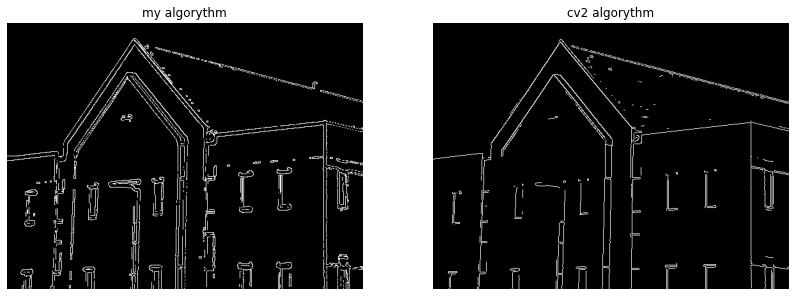

In [48]:
house_my_algo = canny(house, TH=60, TL=20)
house_cv2 = cv2.Canny(house, 250, 300, None, 3, 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
ax[0].imshow(house_my_algo, 'gray'), ax[0].axis('off'), ax[0].set_title('my algorythm')
ax[1].imshow(house_cv2, 'gray'), ax[1].axis('off'), ax[1].set_title('cv2 algorythm')

## Wnioski:
- pełna implementacja tego algorytmu daje niesamowicie dobre efekty,
- krawędzie są niezwykle dokładnie wykryte, nawet w porównaniu z algorytmem cv2,
- jednak dalej, ze względu na stabilność rozwiązanie z opencv jest o wiele lepsze,
- dodatkowo, nie jesteśmy w stanie tak dobrać lower/upper threshold, aby nie wykrywało niektórych krawędzi, bez zanikania obrysu domu.